
<a href="https://colab.research.google.com/github/takzen/pytorch-black-belt/blob/main/30_Learning_Rate_Schedulers.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🥋 Lekcja 30: Learning Rate Schedulers (Sztuka hamowania)

Ustawienie stałego Learning Rate (LR) to błąd.
1.  **Warmup:** Na starcie gradienty są niestabilne. Zaczynamy od zera i powoli zwiększamy LR.
2.  **Decay:** Pod koniec treningu chcemy precyzji. Zmniejszamy LR.

PyTorch ma do tego moduł `torch.optim.lr_scheduler`.
Scheduler "owija" optymalizator i modyfikuje jego wewnętrzne ustawienia.

Przetestujemy 3 najważniejsze strategie:
1.  **LambdaLR:** Pełna kontrola (własna funkcja).
2.  **CosineAnnealing:** Standard w nowoczesnym Deep Learningu (łagodne opadanie).
3.  **OneCycle:** Agresywna strategia "góra-dół" (najszybsza zbieżność).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Prosty model i optymalizator (tylko do symulacji)
model = nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.1) # Bazowy LR = 0.1

print(f"Startowy LR: {optimizer.param_groups[0]['lr']}")

Startowy LR: 0.1


## 1. LambdaLR (Zrób to sam)

To najbardziej elastyczny scheduler.
Podajemy mu funkcję `lambda epoch: mnożnik`.
Nowy LR to: `base_lr * mnożnik`.

Zrobimy klasyczny **Warmup**: przez pierwsze 10 epok LR rośnie liniowo, potem jest stały.

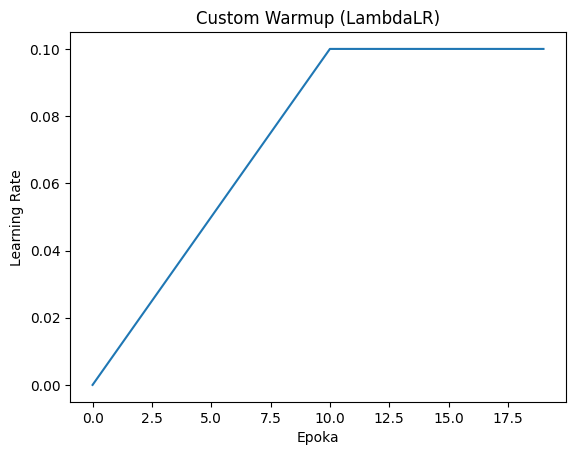

In [2]:
# Funkcja mnożnika
def warmup_fn(epoch):
    if epoch < 10:
        return epoch / 10  # Rośnie: 0.0, 0.1, ... 0.9
    return 1.0             # Stały: 1.0

# Tworzymy scheduler
scheduler_lambda = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_fn)

# Symulacja treningu
lrs = []
for epoch in range(20):
    # 1. Trenujemy...
    optimizer.step()
    
    # 2. Zapisujemy obecny LR (do wykresu)
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    
    # 3. Scheduler aktualizuje LR na następną epokę
    scheduler_lambda.step()

# Wykres
plt.plot(lrs)
plt.title("Custom Warmup (LambdaLR)")
plt.xlabel("Epoka")
plt.ylabel("Learning Rate")
plt.show()

## 2. Cosine Annealing (Standard SOTA)

Używany w GPT, ViT i większości nowoczesnych papierów.
LR spada w kształcie połowy cosinusa.
Dlaczego to dobre? Bo nie ma gwałtownych spadków (schodków), tylko płynne hamowanie.

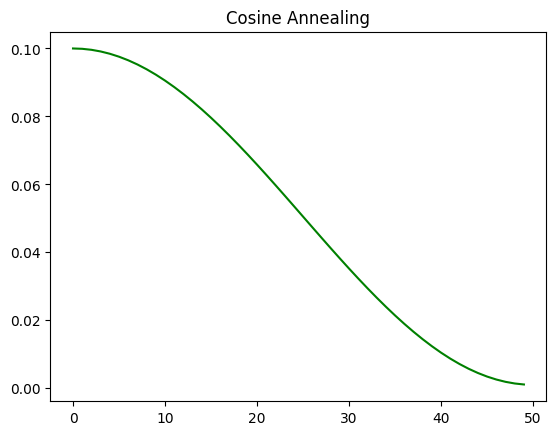

In [3]:
# Reset optymalizatora
optimizer = optim.SGD(model.parameters(), lr=0.1)

# T_max = 50 (długość cyklu - np. liczba epok)
# eta_min = 0.001 (minimalny LR na końcu)
scheduler_cos = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.001)

lrs = []
for epoch in range(50):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler_cos.step()

plt.plot(lrs, color='green')
plt.title("Cosine Annealing")
plt.show()

## 3. OneCycleLR (Super-Convergence)

To "magiczna" technika Lesliego Smitha.
Zamiast zaczynać wysoko i spadać, robimy **górę**.
1.  Startujemy nisko.
2.  Bardzo szybko rośniemy do max LR (agresywna nauka).
3.  Powoli spadamy do zera.

To pozwala wytrenować model **10x szybciej** niż standardowe metody.
**Uwaga:** Ten scheduler wywołuje się **co batch**, a nie co epokę!

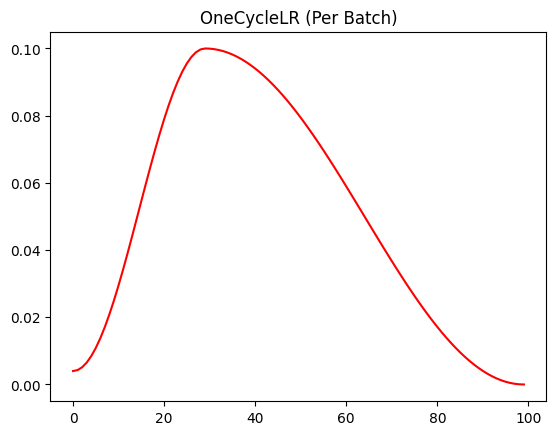

In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Konfiguracja OneCycle
# max_lr: Najwyższy punkt górki
# total_steps: Ile razy zawołamy .step() (epoki * batche)
scheduler_onecycle = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.1, 
    total_steps=100,
    pct_start=0.3 # W 30% czasu osiągamy szczyt
)

lrs = []
for step in range(100): # Symulacja 100 kroków (batchy)
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    
    # WAŻNE: OneCycle stepujemy co batch!
    scheduler_onecycle.step()

plt.plot(lrs, color='red')
plt.title("OneCycleLR (Per Batch)")
plt.show()

## 🥋 Black Belt Summary

1.  **Kiedy wołać `.step()`?**
    *   Większość schedulerów (`StepLR`, `CosineAnnealing`): **Raz na epokę** (po pętli batchy).
    *   `OneCycleLR` (i transformery z warmupem): **Raz na batch** (wewnątrz pętli). Jeśli zrobisz to raz na epokę, model niczego się nie nauczy (LR zmieni się za wolno).
2.  **Co wybrać?**
    *   Domyślnie: **AdamW + Cosine Schedule**.
    *   Szybki trening (mało czasu): **SGD + OneCycle**.
3.  **Pułapka Wznawiania:** Jeśli wznawiasz trening z checkpointu, musisz zapisać też `scheduler.state_dict()`. Inaczej scheduler zresetuje się do początku (wysokie LR) i zepsuje to, co model już umie.